133


ValueError: The parameter `image` cannot be an empty array

<Figure size 432x288 with 0 Axes>

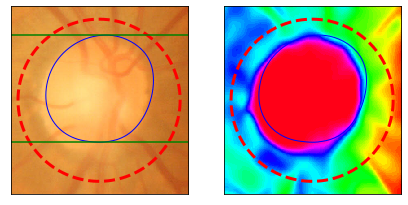

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.segmentation import active_contour
import math
import glob
from os import path

#ไม่ได้ใช้ เขียนไว้ประดับเล่น
def gamma_correction(img, correction):
    img = img/255.0
    img = cv2.pow(img, correction)
    return np.uint8(img*255)

#path ที่เก็บรูปต้นฉบับ แก้ตามในเครื่อง
directoryPath = "RAW_FUNDUS_INPUT/*." 
types = ["jpg", "jpeg"]
listOfImages = []

for extension in types:
    listOfImages.extend(glob.glob( directoryPath + extension ))
    
#ตรงนี้ก็สำคัญ เป็น path ที่เอาไว้ save รูป ตั้งค่าตามใจชอบ อยากให้ไปอยู่ตรงไหนก็เอามาใส่    
savepath = "temp image/"

#เอาไว้ตั้งชื่อรูป บรรทัดที่เขียนว่า fig.savefig
i = 1

for image in listOfImages:
    img = cv2.imread(image)
    
    #ย่อขนาดรูปโดยหาร 2
    row, column = np.shape(img[:,:,0])
    if row%2 == 0:
        row = int(row/2)
    else:
        row = int((row+1)/2)
    if column%2 ==0:
        column = int(column/2)
    else:
        column = int((column+1)/2)
    img = cv2.resize(img,(int(column),int(row))) 
    
    #OpenCV อ่านรูปแล้วเรียง channel สีเป็น BGR เลยต้องเปลี่ยนเป็น RGB ไม่งั้น matplotlib พลอตออกมาสีจะเพี้ยน
    original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #ตั้งค่าให้ matplotlib พลอตสี hsv colorspace ได้ และเปลี่ยนรูป BGR เป็น hsv
    plt.hsv()
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
#    cv2.imshow("hsv",hsv[:,:,2])
#    cv2.waitKey(0)
    
    #It's not essential now
    #img_gamma = gamma_correction(hsv[:,:,2],0.5)
    #cv2.imshow("hsv",img_gamma)
    #cv2.waitKey(0)
    
    #ฟังก์ชั่นไว้ลด noise รูป
    img_denoise = cv2.fastNlMeansDenoising(hsv[:,:,2],None,7,21)
    
    #เลือก ROI 
    ROI = cv2.selectROI(img_denoise)
    cv2.waitKey(0)
    img = img_denoise[int(ROI[1]):int(ROI[1]+ROI[3]), int(ROI[0]):int(ROI[0]+ROI[2])]
    original = original[int(ROI[1]):int(ROI[1]+ROI[3]), int(ROI[0]):int(ROI[0]+ROI[2])]
    
    #สร้างขอบเขตเริ่มต้นของวงกลมที่จะให้มันหดเข้าไปหาขอบของ object 
    s = np.linspace(0, 2*np.pi, 400)
    r = int(img.shape[0]/2)
    c = int(img.shape[1]/2)
    #radius = int(input("Enter radius : "))
    radius = 100
    r = r + radius*np.sin(s) 
    c = c + radius*np.cos(s)
    init = np.array([r, c]).T
    
    #สร้างวงกลมที่จะหดเข้าไปหา object ด้วย active contour
    snake = active_contour(img, init, alpha=0.05, beta=70, w_line=0.1, w_edge=2, gamma=0.001, 
                            max_px_move=1.0, max_iterations=2000, convergence=0.5)
    
    #พลอตวงกลม active contour บนรูปเดิม
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(original)
    ax[0].plot(init[:, 1], init[:, 0], '--r', lw=3)
    ax[0].plot(snake[:, 1], snake[:, 0], '-b', lw=1)
    ax[0].set_xticks([]), ax[0].set_yticks([])
    ax[0].axis([0, original.shape[1], original.shape[0], 0])
    
    #พลอตที่มาของวงกลม ซึ่งวงจาก hsv colorspace 
    ax[1].imshow(img)
    ax[1].plot(init[:, 1], init[:, 0], '--r', lw=3)
    ax[1].plot(snake[:, 1], snake[:, 0], '-b', lw=1)
    ax[1].set_xticks([]), ax[1].set_yticks([])
    ax[1].axis([0, img.shape[1], img.shape[0], 0])
    
    #save fig ตาม savepath ที่ตั้งไว้ด้านบน 
    #path.join ไว้สั่งให้เซฟรูปไปที่ savepath ที่เราต้องการ
    #ตั้งชื่อตาม loop โดยใส่ปีกกา แล้วข้างในให้เป็นตัวเลขเริ่มต้นค่าเดียวกับค่าเริ่มต้นด้านบน (i=0) 
    #.format(i+1) คือสั่งให้ชื่อตามข้างในวงเล็บ ซึ่งจะเริ่มต้นที่ 0+1 = 1
    fig.savefig((path.join(savepath,'{0}.jpg'.format(i))),dpi=300)
    #พอวนลูปค่าจะเพิ่ม ก็คือเอาไว้ตั้งชื่อรูปถัดไป
    i = i+1
    
    #หาตำแหน่งขอบบนสุด-ล่างสุดของวง contour
    maxval = max(snake[:, 0])
    minval = min(snake[:, 0])
    
    #สร้างข้อมูลสำหรับพลอต จุดในแกน x ตั้งแต่ pixel 0 ถึง column สุดท้าย
    #สร้างข้อมู
    x = np.linspace(0,column,num=column)
    y1 = np.ones(column)*int(maxval)
    y2 = np.ones(column)*int(minval)
    
    #พลอตเส้นขอบบน-ล่าง
    ax[0].plot(x,y1,'-g')
    ax[0].plot(x,y2,'-g')
    
    #ระยะระหว่างเส้นขอบบน-ล่าง(math.ceil คือ ปัดเศษ)
    distance = maxval-minval
    print(math.ceil(distance))